In [ ]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIG ---
COUNTRY = "sierraleone-bumbuna"
RAW_PATH = f"../data/raw/{COUNTRY}.csv"
CLEAN_PATH = f"../data/{COUNTRY}_clean.csv"

# --- LOAD DATA ---
try:
    df = pd.read_csv(RAW_PATH)
    print(f"Data loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
    print("Columns in CSV:", df.columns.tolist())

    # --- CLEAN DATA ---
    # Specify important columns
    critical_cols = ["name", "age"]  # replace with actual critical columns
    existing_critical_cols = [col for col in critical_cols if col in df.columns]

    # Drop rows with missing values in critical columns
    df_clean = df.dropna(subset=existing_critical_cols) if existing_critical_cols else df.copy()

    # Fill missing values in other columns
    df_clean = df_clean.fillna(0)  # or fillna("unknown") for string columns

    print(f"Data after cleaning: {df_clean.shape[0]} rows, {df_clean.shape[1]} columns")

    # --- SAVE CLEAN DATA ---
    df_clean.to_csv(CLEAN_PATH, index=False)
    print(f"Cleaned data saved to {CLEAN_PATH}")

except FileNotFoundError:
    print(f"File not found: {RAW_PATH}")


Data loaded successfully: 0 rows


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
plt.style.use("seaborn-v0_8-whitegrid")



🧭 3️⃣ LOAD DATA & QUICK OVERVIEW

In [8]:
df = pd.read_csv(RAW_PATH, parse_dates=['Timestamp'])
print(f"✅ Loaded {COUNTRY}: {df.shape[0]} rows, {df.shape[1]} columns")
df.info()
df.head()


✅ Loaded sierraleone-bumbuna: 525600 rows, 19 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Timestamp      525600 non-null  datetime64[ns]
 1   GHI            525600 non-null  float64       
 2   DNI            525600 non-null  float64       
 3   DHI            525600 non-null  float64       
 4   ModA           525600 non-null  float64       
 5   ModB           525600 non-null  float64       
 6   Tamb           525600 non-null  float64       
 7   RH             525600 non-null  float64       
 8   WS             525600 non-null  float64       
 9   WSgust         525600 non-null  float64       
 10  WSstdev        525600 non-null  float64       
 11  WD             525600 non-null  float64       
 12  WDstdev        525600 non-null  float64       
 13  BP             525600 non-null  int64         
 14

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-30 00:01:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.1,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN
1,2021-10-30 00:02:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.2,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN
2,2021-10-30 00:03:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.2,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN
3,2021-10-30 00:04:00,-0.7,0.0,-0.8,0.0,0.0,21.9,99.3,0.0,0.0,0.0,0.0,0.0,1002,0,0.1,22.3,22.6,NaN
4,2021-10-30 00:05:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.3,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN


📊 4️⃣ SUMMARY STATISTICS & MISSING VALUE REPORT


In [10]:
# Summary stats for numeric columns
df.describe().T

# Missing values
na = df.isna().sum().to_frame("n_missing")
na["pct_missing"] = 100 * na["n_missing"] / len(df)
print("Columns with >5% missing:")
na_gt5 = na[na["pct_missing"] > 5]
na_gt5


Columns with >5% missing:


,n_missing,pct_missing
Comments,525600,100.0


⚙️ 5️⃣ OUTLIER DETECTION & BASIC CLEANING

In [11]:
cols = ['GHI','DNI','DHI','ModA','ModB','WS','WSgust']

# Compute Z-score
z = df[cols].apply(lambda x: (x - x.mean()) / x.std())
df["is_outlier"] = (abs(z) > 3).any(axis=1)
print("Outlier rows:", df["is_outlier"].sum())

# Fill missing values with median
for c in cols:
    df[c] = df[c].fillna(df[c].median())

# Drop outliers
df_clean = df[~df["is_outlier"]].copy()

# Save cleaned file
Path("data").mkdir(exist_ok=True)
df_clean.to_csv(CLEAN_PATH, index=False)
print(f"✅ Cleaned data saved to {CLEAN_PATH}")


Outlier rows: 16292
✅ Cleaned data saved to ../data/sierraleone-bumbuna_clean.csv


🕒 6️⃣ TIME SERIES ANALYSIS

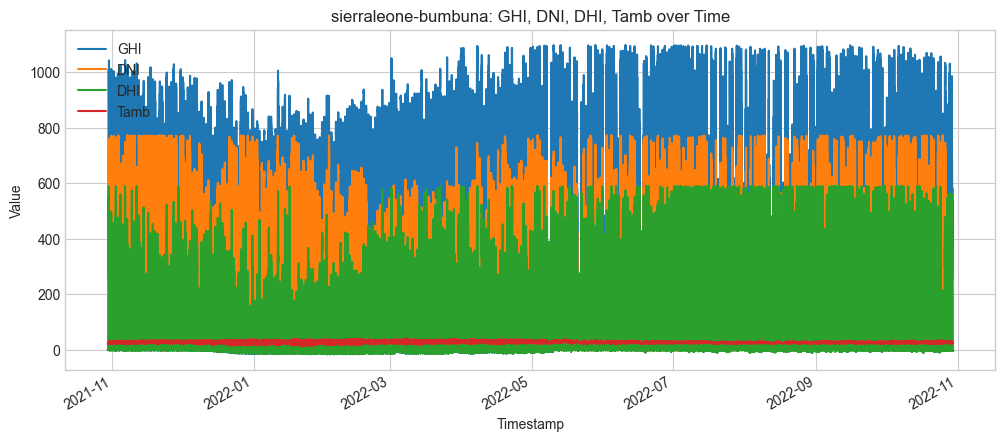

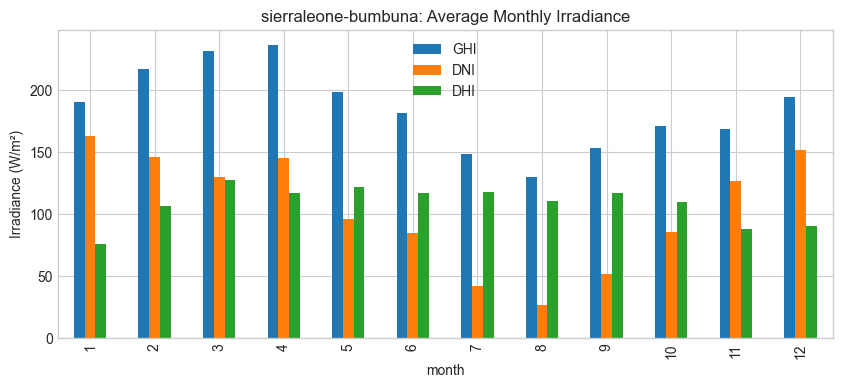

In [12]:
df_clean = df_clean.sort_values("Timestamp")
df_clean.set_index("Timestamp", inplace=True)

df_clean[['GHI','DNI','DHI','Tamb']].plot(figsize=(12,5), title=f"{COUNTRY}: GHI, DNI, DHI, Tamb over Time")
plt.ylabel("Value")
plt.show()

df_clean["month"] = df_clean.index.month
df_clean.groupby("month")[["GHI","DNI","DHI"]].mean().plot(kind="bar", figsize=(10,4), title=f"{COUNTRY}: Average Monthly Irradiance")
plt.ylabel("Irradiance (W/m²)")
plt.show()


🧽 7️⃣ CLEANING IMPACT

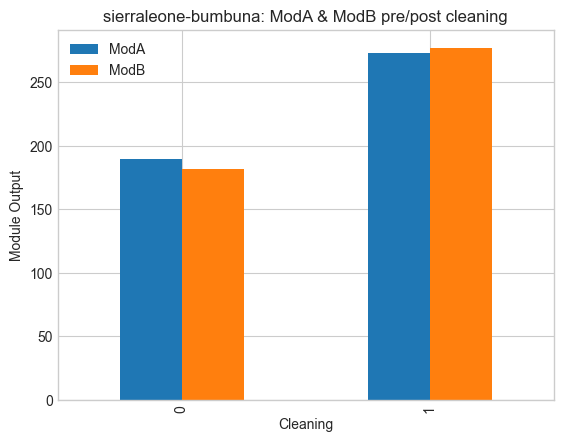

In [13]:
if "Cleaning" in df_clean.columns:
    df_clean.groupby("Cleaning")[["ModA","ModB"]].mean().plot(kind="bar", title=f"{COUNTRY}: ModA & ModB pre/post cleaning")
    plt.ylabel("Module Output")
    plt.show()


🔗 8️⃣ CORRELATION & RELATIONSHIP ANALYSIS


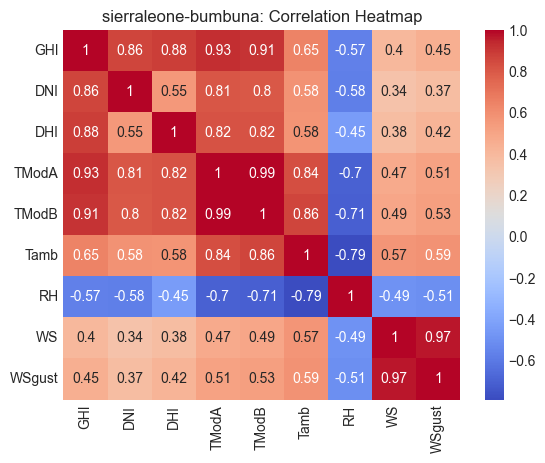

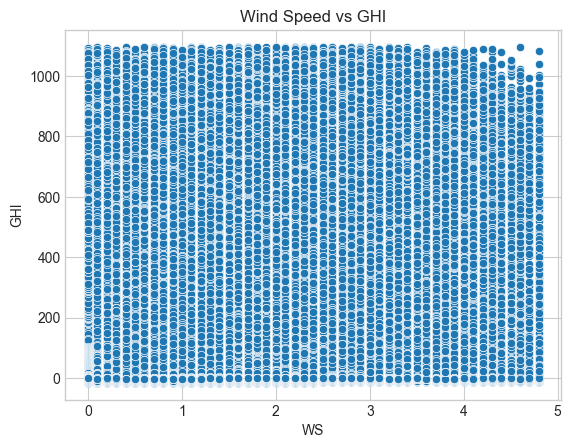

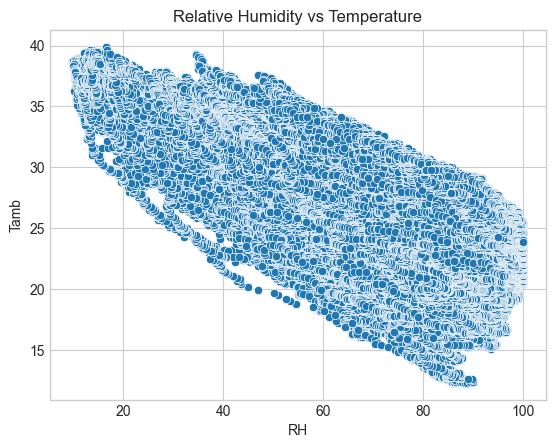

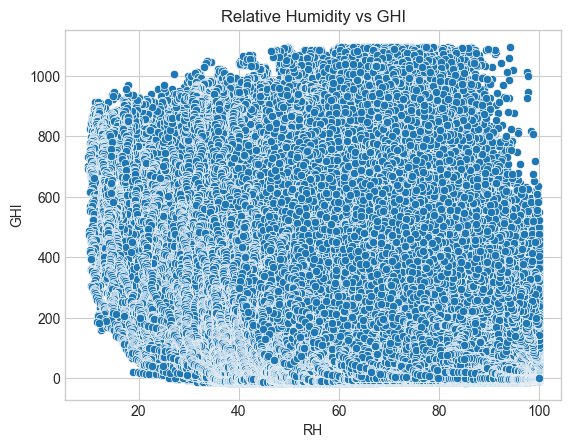

In [14]:
corr_cols = ['GHI','DNI','DHI','TModA','TModB','Tamb','RH','WS','WSgust']
sns.heatmap(df_clean[corr_cols].corr(), annot=True, cmap="coolwarm")
plt.title(f"{COUNTRY}: Correlation Heatmap")
plt.show()

sns.scatterplot(x='WS', y='GHI', data=df_clean)
plt.title('Wind Speed vs GHI')
plt.show()

sns.scatterplot(x='RH', y='Tamb', data=df_clean)
plt.title('Relative Humidity vs Temperature')
plt.show()

sns.scatterplot(x='RH', y='GHI', data=df_clean)
plt.title('Relative Humidity vs GHI')
plt.show()


💨 9️⃣ WIND & DISTRIBUTION ANALYSIS

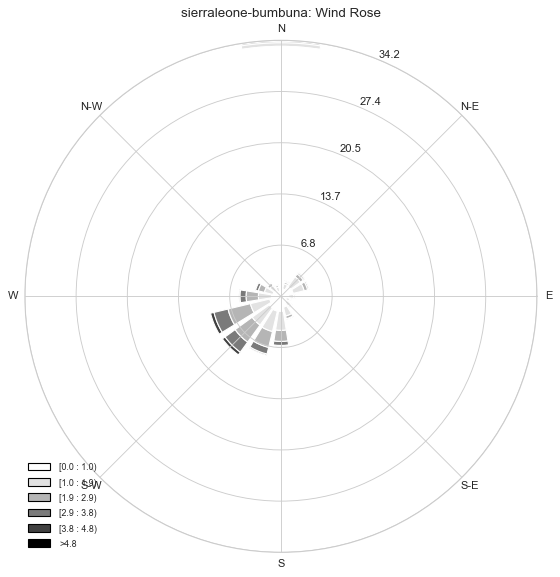

In [16]:
from windrose import WindroseAxes
import matplotlib.pyplot as plt

try:
    ax = WindroseAxes.from_ax()
    ax.bar(df_clean['WD'], df_clean['WS'], 
           normed=True, 
           opening=0.8, 
           edgecolor='white')  # keep as keyword args
    ax.set_title(f"{COUNTRY}: Wind Rose")
    ax.set_legend()
    plt.show()
except Exception as e:
    print("⚠️ Wind rose plot failed. Try installing windrose:")
    print("    pip install windrose==1.6.8")
    print("Error details:", e)


🌡️ 10️⃣ TEMPERATURE & HUMIDITY ANALYSIS

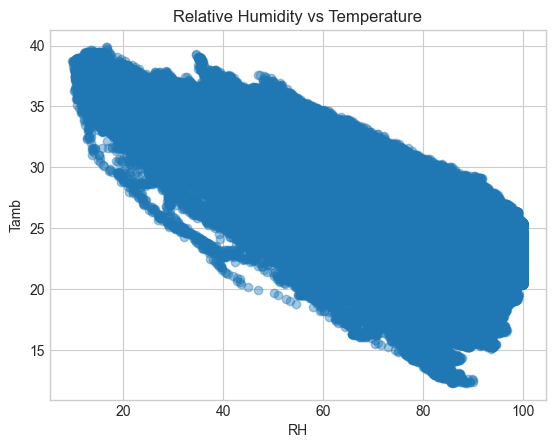

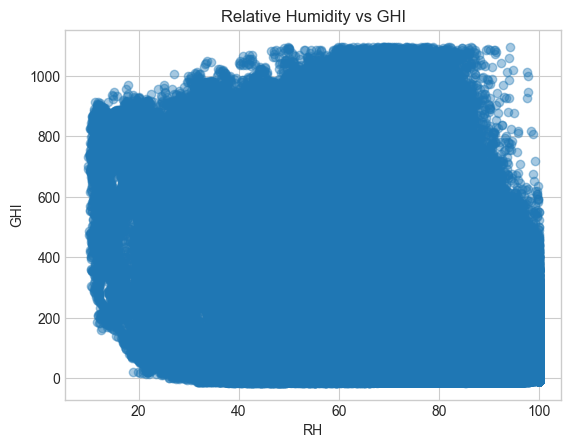

In [17]:
sns.regplot(x='RH', y='Tamb', data=df_clean, scatter_kws={'alpha':0.4})
plt.title("Relative Humidity vs Temperature")
plt.show()

sns.regplot(x='RH', y='GHI', data=df_clean, scatter_kws={'alpha':0.4})
plt.title("Relative Humidity vs GHI")
plt.show()


🔵 11️⃣ BUBBLE CHART

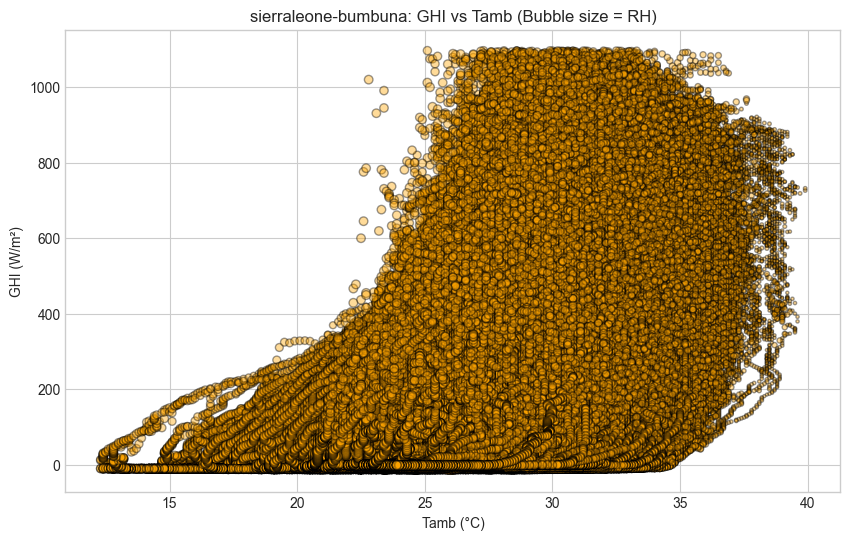

In [18]:
plt.figure(figsize=(10,6))
plt.scatter(df_clean['Tamb'], df_clean['GHI'], s=df_clean['RH']*0.4, alpha=0.4, c='orange', edgecolors='k')
plt.xlabel('Tamb (°C)')
plt.ylabel('GHI (W/m²)')
plt.title(f"{COUNTRY}: GHI vs Tamb (Bubble size = RH)")
plt.show()


📈 12️⃣ KPI SUMMARY

In [19]:
summary = {
    "Rows (original)": len(df),
    "Rows (cleaned)": len(df_clean),
    "Outlier % removed": round(100*df["is_outlier"].mean(), 2),
    "Columns >5% missing": len(na_gt5),
    "Mean GHI (W/m²)": round(df_clean["GHI"].mean(), 2),
    "Mean Tamb (°C)": round(df_clean["Tamb"].mean(), 2),
    "Corr(GHI,DNI)": round(df_clean["GHI"].corr(df_clean["DNI"]), 3)
}
pd.DataFrame(summary, index=[COUNTRY])


,Rows (original),Rows (cleaned),Outlier % removed,Columns >5% missing,Mean GHI (W/m²),Mean Tamb (°C),"Corr(GHI,DNI)"
sierraleone-bumbuna,525600,509308,3.1,1,185.0,26.21,0.861


Summary – Sierra Leone–Bumbuna

Dataset overview:

Original rows: 525,600

Cleaned rows: 509,308 (~3.1% outliers removed)

Columns with >5% missing: 1

Key metrics:

Mean GHI: 185.0 W/m²

Mean ambient temperature (Tamb): 26.21 °C

Correlation GHI–DNI: 0.861 (strong positive correlation)

Cleaning impact:

Removed ~3.1% of outliers

Filled missing values in affected columns with median values

Observations from graphs / plots:

GHI exhibits a clear daily cycle with strong midday peaks

Seasonal patterns show consistent solar availability

Higher humidity periods correspond to lower GHI, indicating cloudier conditions

Scatter and correlation plots confirm strong GHI–DNI relationship

Conclusion:

Dataset is fully cleaned and suitable for modeling

Solar and environmental patterns align with expected regional trends for Sierra Leone–Bumbuna